## Multimodal Learning

In [18]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import Dataset
import random
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [19]:
#Adopted from:
# Multi-Domain Translation between Single-Cell Imaging and Sequencing Data using Autoencoders
# https://github.com/uhlerlab/cross-modal-autoencoders

class FC_Autoencoder(nn.Module):
    def __init__(self, n_input, latent_variable_size, n_hidden=512):
        super(FC_Autoencoder, self).__init__()
        self.latent_variable_size = latent_variable_size
        self.n_input = n_input
        self.n_hidden = n_hidden

        
        self.encoder = nn.Sequential(
            nn.Linear(self.n_input, n_hidden),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
        )
        

        self.fc1 = nn.Linear(n_hidden, latent_variable_size)
        self.fc2 = nn.Linear(n_hidden, latent_variable_size)


        self.decoder = nn.Sequential(
            nn.Linear(latent_variable_size, n_hidden),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_input),
        )

    def forward(self, x):
        mu, logvar = self.encode(x)
        latent_space = self.reparametrize(mu, logvar)
        res = self.decode(latent_space)
        return res, latent_space, mu, logvar
    

    def encode(self, x):
        h = self.encoder(x)       
        return self.fc1(h), self.fc2(h)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        return self.decoder(z)

    def get_latent_var(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z
 
    def generate(self, z):
        res = self.decode(z)
        return res


In [44]:
def preprocess (Essentiality, Expression):

    dataset_processed = dict()
    common_cells = set(Expression.index)  & set(Essentiality.index)
    for cell in common_cells:

        dataset_processed[cell] = {
            "data_ess": torch.tensor(Essentiality.loc[cell]),
            "data_exp": torch.tensor(Expression.loc[cell])
        }
        
    ess_gene_list, exp_gene_list = list(Essentiality.columns), list(Expression.columns)
    return dataset_processed, ess_gene_list, exp_gene_list


class JointDataset(Dataset):
    def __init__(self, dataset, from_keys):
        
        self.data_ess = []
        self.data_exp = []
        self.cell_line = []

        self.keys = from_keys
        
        for cell in from_keys: #dataset.keys():
            self.data_ess.append(dataset[cell]["data_ess"])
            self.data_exp.append(dataset[cell]["data_exp"])
            self.cell_line.append(cell)
    
        self.data_ess = torch.stack(self.data_ess).float()
        self.data_exp = torch.stack(self.data_exp).float()
        
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, index):
        return self.data_ess[index], self.data_exp[index], self.cell_line[index]
    

def load_data(batch_size = None, val_split=False,drug=False):
    
    if drug:

        Essentiality = pd.read_csv("data/primary-screen-replicate-collapsed-logfold-change.csv"
                                  ).rename(columns={"Unnamed: 0": 'CellLine'}).set_index('CellLine')
        Essentiality = Essentiality.fillna(Essentiality.mean())
        Essentiality.columns = Essentiality.columns.str.replace(r'[^a-zA-Z0-9]', '.', regex=True)

        with open("data/top500_variable_drug.txt", 'r') as file:
            variable_drug = file.read().splitlines()
            
        Essentiality = Essentiality[variable_drug]
        
    else:

        Essentiality = pd.read_csv("data/CRISPRGeneEffect.csv"
                                  ).rename(columns={"ModelID":
                                                    'CellLine'}).set_index('CellLine')  
        
        Essentiality.columns = [col.split(" ")[0] for col in Essentiality.columns]


    Expression = pd.read_csv("data/OmicsExpressionProteinCodingGenesTPMLogp1.csv").rename(
        columns={"Unnamed: 0": 'CellLine'}).set_index('CellLine')
    Expression.columns = [col.split(" ")[0] for col in Expression.columns]
    
    Joint_data, ess_gene_list, exp_gene_list = preprocess(Essentiality, Expression)

    random_cell_line = random.choice(list(Joint_data.keys()))
    n_input_ess = Joint_data[random_cell_line]["data_ess"].size(0)
    n_input_exp = Joint_data[random_cell_line]["data_exp"].size(0)

    if val_split:
        train_cells, val_cells = train_test_split(list(Joint_data.keys()), test_size=0.3, random_state=42)
        val_cells, test_cells = train_test_split(val_cells, test_size=0.5, random_state=42)
    
        train_data = JointDataset(Joint_data, train_cells)
        val_data =  JointDataset(Joint_data, val_cells)
        test_data =  JointDataset(Joint_data, test_cells)
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    else:
        train_cells, test_cells = train_test_split(list(Joint_data.keys()), test_size=0.2, random_state=42)
        
        train_data = JointDataset(Joint_data, train_cells)
        test_data =  JointDataset(Joint_data, test_cells)

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        val_loader = None
        val_data = []

    print(f"Split:{len(train_data)}, Size of Val:{len(val_data)}, Size of Test: {len(test_data)}")
    print(f"Essentiality: {train_loader.dataset[0][0].shape} x {len(ess_gene_list)}")
    print(f"Expression: {train_loader.dataset[0][1].shape} x {len(exp_gene_list)}")

    return train_loader, val_loader, test_loader, n_input_ess, n_input_exp, ess_gene_list, exp_gene_list


### Model definitions 

In [45]:
def compute_KL_loss(mu, logvar,lambda_=1e-08):
    if lambda_>0:
        KLloss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return lambda_ * KLloss
    
    return 0

def train(loader, model_ess, model_exp, opt="adam", alpha=0.5, beta=0.5, lr= 1e-3, device="cuda"):
    
    model_ess.train()
    model_exp.train()

    MSELoss = nn.MSELoss()

    parameters = list(model_ess.parameters()) + list(model_exp.parameters())
    if opt.lower() == "adam":
        optimizer = optim.Adam(parameters, lr=lr)
        
    elif opt.lower() == "adamw":
        optimizer = optim.AdamW(parameters, lr=lr)
        
    elif opt.lower() == "adagrad":
        optimizer = optim.Adagrad(parameters, lr=lr)
        
    elif opt.lower() == "sgd":
        optimizer = optim.SGD(parameters, lr=lr)
    else:
        raise ValueError(f"Optimizer value error :{opt}")
       
    train_loss = 0
    for batch in loader:
        
        data_ess, data_exp = batch[0].to(device) , batch[1].to(device)
        
        #Reconstruction
        decoded_ess, _ , mu_ess, logvar_ess = model_ess(data_ess)
        decoded_exp, latent_exp, mu_exp, logvar_exp = model_exp(data_exp)

        loss_ess = MSELoss(data_ess, decoded_ess)
        loss_exp = MSELoss(data_exp, decoded_exp)

        #Decoding from latent space
        pred_ess = model_ess.decode(latent_exp)
        loss_pred = MSELoss (data_ess, pred_ess )

        #Kl-Loss
        kl_loss = compute_KL_loss(mu_ess, logvar_ess) + compute_KL_loss(mu_exp, logvar_exp)
        
        
        total_loss = alpha*(loss_ess + loss_exp) + (beta)* loss_pred + (1-alpha-beta)* kl_loss
       
        optimizer.zero_grad()        
        total_loss.backward()
        optimizer.step()
        
        train_loss += total_loss.item()
    
    train_loss /= len(loader)
    return train_loss, model_ess, model_exp


def evaluate(loader, model_ess, model_exp, device="cuda"):
    
    model_ess.eval()
    model_exp.eval() 
    MSELoss = nn.MSELoss()

    y_ess_pred = []
    y_ess_true = []

    val_loss = 0
    with torch.no_grad():
        for batch in loader:
            
            data_ess, data_exp = batch[0].to(device) , batch[1].to(device)
            _, latent_exp, _, _ = model_exp(data_exp)
            pred_ess = model_ess.decode(latent_exp)

            total_loss = MSELoss(data_ess, pred_ess)
            val_loss += total_loss.item()

            y_ess_pred.append(pred_ess)
            y_ess_true.append(data_ess)
    y_ess_pred = torch.cat(y_ess_pred, dim=0).detach().cpu().numpy()
    y_ess_true = torch.cat(y_ess_true, dim=0).detach().cpu().numpy()

    val_loss /= len(loader)
    return val_loss, y_ess_pred, y_ess_true


In [46]:
import time


latent_size = int(10e3) #1024
batch_size = 40
lr = 0.0001
epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alpha = 0.4
beta = 0.5
opt="adam"

(
    train_loader, val_loader, test_loader, n_input_ess, n_input_exp, ess_gene_list, exp_gene_list
)= load_data(batch_size = batch_size, val_split=True, drug=True)

model_ess = FC_Autoencoder(n_input_ess, latent_size).to(device)
model_exp = FC_Autoencoder(n_input_exp, latent_size).to(device) 


optimal_loss = float('inf')
for epoch in range(epochs):

    start_time = time.time()
    print(f"Epoch {epoch+1} of {epochs}")
    print("-------------------------------")
    
    train_loss, model_ess_t, model_exp_t = train(train_loader, model_ess, model_exp, opt=opt, alpha=alpha, beta=beta, lr=lr, device=device)
    val_loss, y_ess_pred, y_ess_true = evaluate(val_loader, model_ess, model_exp, device=device)

    if val_loss < optimal_loss:
        optimal_loss = val_loss
        torch.save(model_ess_t.state_dict(), "baselines/VAE_baseline/model_ess_var.pt")
        torch.save(model_exp_t.state_dict(), "baselines/VAE_baseline/model_exp_var.pt")


    print(f'\tET: {time.time() - start_time}\n')

    print(f'\tTrain Loss: {train_loss}\n')
    print(f'\tVal Loss: {val_loss}\n')


/tmp/ipykernel_3469976/3479486273.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "data_ess": torch.tensor(Essentiality.loc[cell]),
/tmp/ipykernel_3469976/3479486273.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "data_exp": torch.tensor(Expression.loc[cell])


Split:390, Size of Val:84, Size of Test: 84
Essentiality: torch.Size([500]) x 500
Expression: torch.Size([19193]) x 19193
Epoch 1 of 50
-------------------------------
	ET: 1.0977818965911865

	Train Loss: 10.292876815795898

	Val Loss: 5.623782793680827

Epoch 2 of 50
-------------------------------
	ET: 1.3361341953277588

	Train Loss: 9.301541805267334

	Val Loss: 4.933698336283366

Epoch 3 of 50
-------------------------------
	ET: 1.33441162109375

	Train Loss: 8.374310207366943

	Val Loss: 4.149767239888509

Epoch 4 of 50
-------------------------------
	ET: 1.3264520168304443

	Train Loss: 7.499209594726563

	Val Loss: 3.6813601652781167

Epoch 5 of 50
-------------------------------
	ET: 0.8791179656982422

	Train Loss: 6.703956413269043

	Val Loss: 3.85650634765625

Epoch 6 of 50
-------------------------------
	ET: 0.8498952388763428

	Train Loss: 6.006777238845825

	Val Loss: 3.948876221974691

Epoch 7 of 50
-------------------------------
	ET: 1.3438818454742432

	Train Los

In [42]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

def get_corrcoef (data1 , data2, dim=0, corr="spearman"):
    
    if isinstance(data1, torch.Tensor):

        if data1.is_cuda:
            data1 = data1.cpu().detach().numpy()
            data2 = data2.cpu().detach().numpy()
        else:
            data1 = data1.detach().numpy()
            data2 = data2.detach().numpy()

    elif isinstance(data1, pd.DataFrame):
        data1 = data1.values
        data2 = data2.values
            
    if corr.lower() == "pearson":
        
        if dim == 0:
            corrcoef =[np.corrcoef(data1[:,i], data2[:,i])[0, 1] for i in range(data1.shape[1])]
            corrcoef = np.array(corrcoef)
            corrcoef = corrcoef[~np.isnan(corrcoef)]
        elif dim == 1:
            corrcoef =[np.corrcoef(data1[i,:], data2[i,:])[0, 1] for i in range(data1.shape[0])]
            corrcoef = np.array(corrcoef)
            corrcoef = corrcoef[~np.isnan(corrcoef)]
        else:
            raise ValueError(f"dim value erro: dim={dim}")
        
    elif corr.lower() == "spearman":
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            if dim == 0:
                corrcoef =[spearmanr(data1[:,i], data2[:,i])[0] for i in range(data1.shape[1])]
                corrcoef = np.array(corrcoef)
                corrcoef = corrcoef[~np.isnan(corrcoef)]
            elif dim == 1:
                corrcoef =[spearmanr(data1[i,:], data2[i,:])[0] for i in range(data1.shape[0])]
                corrcoef = np.array(corrcoef)
                corrcoef = corrcoef[~np.isnan(corrcoef)]
            else:
                raise ValueError(f"dim value erro: dim={dim}")

    else:
        raise ValueError(f"Correlation Name Error: {corr}")


    corrcoef = torch.tensor(corrcoef)

    highest_indices = torch.topk(corrcoef, int(0.1 * len(corrcoef)), largest=True).indices
    corrcoef10 = corrcoef[highest_indices] 

    return corrcoef, corrcoef10


def plot_corrcoef_boxplot(predicted_ess, original_ess, save_path=None,
                           merge_actionable_and_top10 =False, title="", show=False):
    

    # Calculate correlation coefficients
    drugs_corrcoef, drugs_corrcoef10 = get_corrcoef(predicted_ess, original_ess, dim=0)
    drugs_corrcoef, drugs_corrcoef10 = np.nan_to_num(drugs_corrcoef, nan=0.0, posinf=0.0, neginf=0.0), np.nan_to_num(drugs_corrcoef10, nan=0.0, posinf=0.0, neginf=0.0)

    cell_corrcoef, cell_corrcoef10 = get_corrcoef(predicted_ess, original_ess, dim=1)
    cell_corrcoef, cell_corrcoef10 = np.nan_to_num(cell_corrcoef, nan=0.0, posinf=0.0, neginf=0.0), np.nan_to_num(cell_corrcoef10, nan=0.0, posinf=0.0, neginf=0.0)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        data = [drugs_corrcoef, drugs_corrcoef10, cell_corrcoef, cell_corrcoef10]
        labels = ['Drugs', 'Drugs 10%', 'Cells', 'Cells 10%']

        bp = plt.boxplot(data, labels=labels,
                         patch_artist=True, showfliers=True, notch=True, meanline=True)
        
        bp['boxes'][0].set_facecolor("lightblue")
        bp['boxes'][1].set_facecolor("lightblue")
        bp['boxes'][2].set_facecolor("brown")
        bp['boxes'][3].set_facecolor("brown")
        
    plt.ylabel('Correlation')
    plt.title(f'{title}', fontsize=10)
    # Ensure the correlation values being displayed are finite
    if np.isfinite(np.median(drugs_corrcoef)):
        plt.text(0.65, np.median(drugs_corrcoef), round(np.median(drugs_corrcoef), 2), fontsize=8, rotation=90)

    if np.isfinite(np.median(drugs_corrcoef10)):
        plt.text(1.65, np.median(drugs_corrcoef10), round(np.median(drugs_corrcoef10), 2), fontsize=8, rotation=90)

    if np.isfinite(np.median(cell_corrcoef)):
        plt.text(2.65, np.median(cell_corrcoef), round(np.median(cell_corrcoef), 2), fontsize=8, rotation=90)

    if np.isfinite(np.median(cell_corrcoef10)):
        plt.text(3.65, np.median(cell_corrcoef10), round(np.median(cell_corrcoef10), 2), fontsize=8, rotation=90)

    # if np.isfinite(np.median(actionable)) and not merge_actionable_and_top10:
    #     plt.text(4.65, np.median(actionable), round(np.median(actionable), 2), fontsize=8, rotation=90)
    
    if save_path:
        plt.savefig(save_path)

    if show:
        plt.show()


In [49]:
model_ess.load_state_dict(torch.load("baselines/VAE_baseline/model_ess_var.pt"))
model_exp.load_state_dict(torch.load("baselines/VAE_baseline/model_exp_var.pt"))
y_ess_pred, y_ess_true = evaluate(test_loader, model_ess, model_exp, device=device)[1:]

In [51]:
#save the predicted and true values as df
pd.DataFrame(y_ess_pred, columns=ess_gene_list).to_csv("baselines/VAE_baseline/y_ess_pred_var.csv")
pd.DataFrame(y_ess_true, columns=ess_gene_list).to_csv("baselines/VAE_baseline/y_ess_true_var.csv")

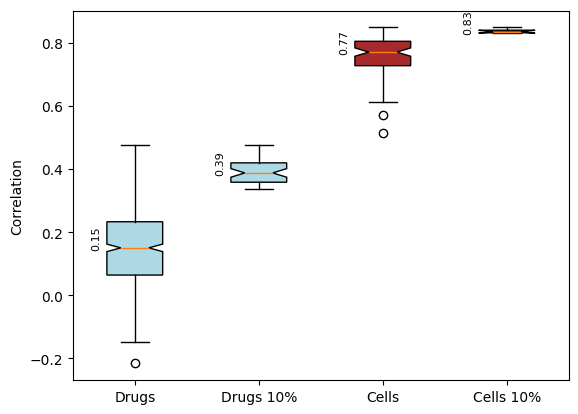

In [52]:
plot_corrcoef_boxplot(y_ess_pred, y_ess_true,
                     save_path="baselines/VAE_baseline/corrcoef_boxplot_var.pdf",
                      title="",
                      show=True)